In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

from scipy.stats import norm
from torch.autograd import Variable
from torch.utils.data.dataloader import DataLoader
from torchvision.datasets import MNIST
from torchvision.utils import make_grid as make_image_grid
from tqdm import tnrange

torch.manual_seed(2017) # reproducability
sns.set_style('dark')
%matplotlib inline

In [2]:
#Model definition
class VAE(nn.Module):
    def __init__(self, latent_dim = 20, hidden_dim = 500):
        super(VAE,self).__init__()
        self.fc_e = nn.Linear(784,hidden_dim)                      #First encoding phase, reduce dimension from 784 - 500
        self.fc_mean = nn.Linear(hidden_dim,latent_dim)            #Second encoding phase, reduce dimension from 500 - 20 obtain mena and logvar
        self.fc_logvar = nn.Linear(hidden_dim,latent_dim)             
        self.fc_d1 = nn.Linear(latent_dim,hidden_dim)              #First decoding phase, increase dim from 20 - 500
        self.fc_d2 = nn.Linear(hidden_dim, 784)                    #Second decoding phase, increase dim from 500 - 784
        
    def encoder(self, x_in):
        x = F.relu(self.fc_e(x_in.view(-1,784)))
        mean = self.fc_mean(x)
        logvar = self.fc_logvar(x)
        return mean, logvar
    
    def decoder (self,z):
        z = F.relu(self.fc_d1(z))
        x_out = F.sigmoid(self.fc_d2(z))
        return x_out.view(-1,1,28,28)
    
    def sample_normal(self,mean,logvar):
        #Using torch.normal(mean,std) returns a stochastic tensor which we cannot backpropagate through.
        #Instead we utilize the 'reparametrization trick'
        # http://stats.stackexchange.com/a/205336
        # http://dpkingma.com/wordpress/wp-content/uploads/2015/12/talk_nips_workshop_2015.pdf
        sd = torch.exp(logvar*0.5)
        e = Variable(torch.randn(sd.size())) #Sample from standard normal
        z = e.mul(sd).add_(mean)
        return z
    
    def forward(self,x_in):
        z_mean, z_logvar = self.encoder(x_in)
        z = self.sample_normal(z_mean,z_logvar)
        x_out = self.decoder(z)
        return x_out, z_mean, z_logvar
    
model = VAE()
print ('Model architecture: ', model)

Model architecture:  VAE(
  (fc_e): Linear(in_features=784, out_features=500)
  (fc_mean): Linear(in_features=500, out_features=20)
  (fc_logvar): Linear(in_features=500, out_features=20)
  (fc_d1): Linear(in_features=20, out_features=500)
  (fc_d2): Linear(in_features=500, out_features=784)
)


In [3]:
#Define loss function
def criterion(x_out,x_in,z_mu,z_logvar):
    bce_loss = F.binary_cross_entropy(x_out,x_in,size_average = False)
    kld_loss = -0.5 * torch.sum(1 + z_logvar - (z_mu**2) - torch.exp(z_logvar)) #figure out this
    loss = (bce_loss + kld_loss) / x_out.size(0) #normalize batch size
    return loss

In [4]:
#Optimizer
optimizer = torch.optim.Adam(model.parameters())

In [5]:
# Data loaders
trainloader = DataLoader(
    MNIST(root='./data',train=True,download=True,transform=transforms.ToTensor()),
    batch_size=128,shuffle=True)
testloader = DataLoader(
    MNIST(root='./data',train=False,download=True,transform=transforms.ToTensor()),
    batch_size=128,shuffle=True)

A Jupyter Widget

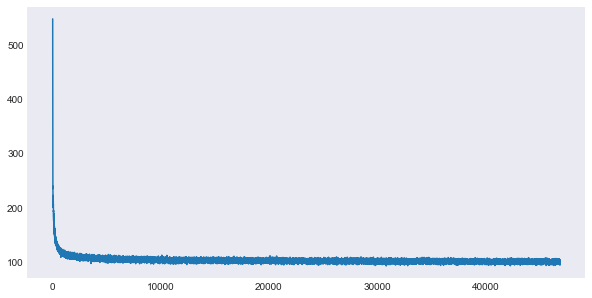

Wall time: 32min 14s


In [6]:
%%time
# Training
def train(model,optimizer,dataloader,epochs=100):
    losses = []
    for epoch in tnrange(epochs,desc='Epochs'):
        for images,_ in dataloader:
            x_in = Variable(images)
            optimizer.zero_grad()
            x_out, z_mu, z_logvar = model(x_in)
            loss = criterion(x_out,x_in,z_mu,z_logvar)
            loss.backward()
            optimizer.step()
            losses.append(loss.data[0])
    return losses

train_losses = train(model,optimizer,trainloader)
plt.figure(figsize=(10,5))
plt.plot(train_losses)
plt.show()

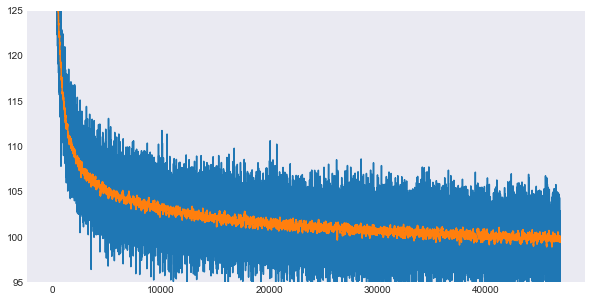

In [7]:
# Visualize moving average of losses
def visualize_losses_moving_average(losses,window=50,boundary='valid',ylim=(95,125)):
    mav_losses = np.convolve(losses,np.ones(window)/window,boundary)
    corrected_mav_losses = np.append(np.full(window-1,np.nan),mav_losses)
    plt.figure(figsize=(10,5))
    plt.plot(losses)
    plt.plot(corrected_mav_losses)
    plt.ylim(ylim)
    plt.show()

visualize_losses_moving_average(train_losses)

In [8]:
# Testing
def test(model,dataloader):
    running_loss = 0.0
    for images, _ in dataloader:
        x_in = Variable(images)
        x_out, z_mu, z_logvar = model(x_in)
        loss = criterion(x_out,x_in,z_mu,z_logvar)
        running_loss = running_loss + (loss.data[0]*x_in.size(0))
    return running_loss/len(dataloader.dataset)

test_loss = test(model,testloader)
print(test_loss)

100.6499818725586


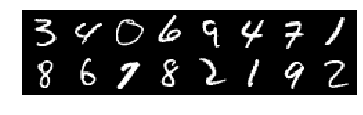

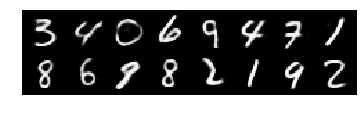

In [9]:
# Visualize VAE input and reconstruction
def visualize_mnist_vae(model,dataloader,num=16):
    def imshow(img):
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg,(1,2,0)))
        plt.axis('off')
        plt.show()
        
    images,_ = iter(dataloader).next()
    images = images[0:num,:,:]
    x_in = Variable(images)
    x_out,_,_ = model(x_in)
    x_out = x_out.data
    imshow(make_image_grid(images))
    imshow(make_image_grid(x_out))

visualize_mnist_vae(model,testloader)

A Jupyter Widget


148.99245808105468


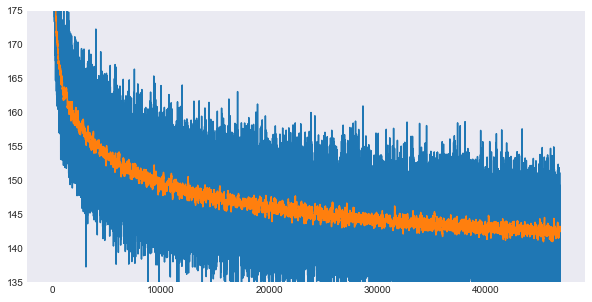

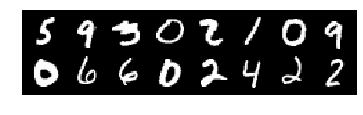

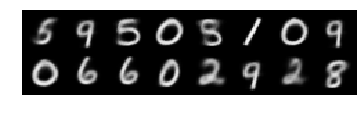

In [10]:
# Train, test and visualize reconstruction using a 2D latent space
model2 = VAE(latent_dim=2)                                 #use a 2D latent dim -> can we use more? how to visualize?
optimizer2 = torch.optim.Adam(model2.parameters())

train2_losses = train(model2,optimizer2,trainloader)
test2_loss = test(model2,testloader)

print(test2_loss)
visualize_losses_moving_average(train2_losses,ylim=(135,175))
visualize_mnist_vae(model2,testloader)

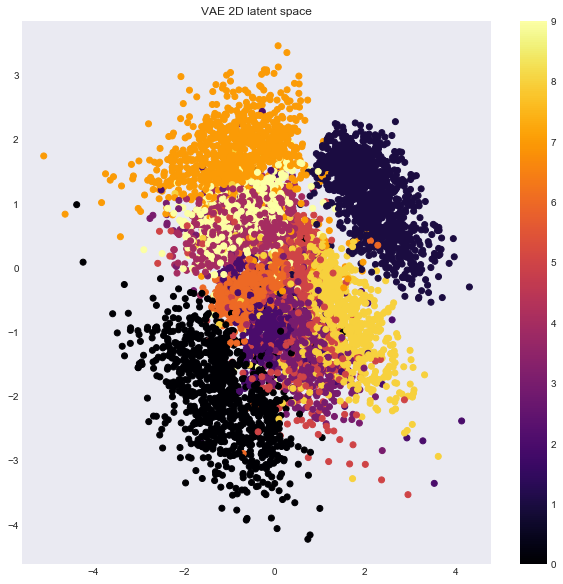

In [11]:
#Visualize test data encodings on the latent space
def visualize_encoder(model,dataloader):
    z_means_x, z_means_y, all_labels = [], [], []
    
    for images,labels in iter(dataloader):
        z_means,_ = model.encoder(Variable(images))
        z_means_x = np.append(z_means_x,z_means[:,0].data.numpy())
        z_means_y = np.append(z_means_y,z_means[:,1].data.numpy())
        all_labels = np.append(all_labels,labels.numpy())
        
    plt.figure(figsize=(10.5,10))
    plt.title("VAE 2D latent space")
    plt.scatter(z_means_x,z_means_y,c=all_labels,cmap='inferno')
    plt.colorbar()
    plt.show()

visualize_encoder(model2,testloader)

In [12]:
#Visualize test data encodings on the latent space
def get_z_means(model,dataloader):
    z_means, all_labels = [], []
    
    for images,labels in iter(dataloader):
        z_means_ ,_ = model.encoder(Variable(images))
        z_means.extend(z_means_[:,:].data.numpy())
        all_labels = np.append(all_labels,labels.numpy())
        
    return np.array(z_means), all_labels

z_means, all_labels = get_z_means(model,testloader)

## Representations of points in latent space - T-SNE

In [13]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [14]:
%%time
z_means_proj = TSNE(n_components=2, perplexity = 30).fit_transform(z_means)
z_means_proj2 = TSNE(n_components=2, perplexity = 50).fit_transform(z_means)

Wall time: 11min 51s


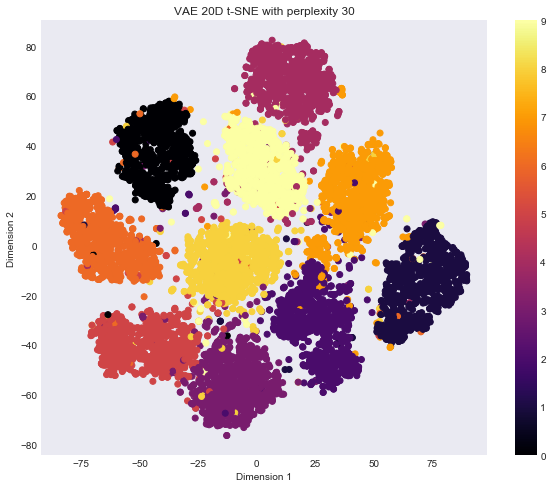

In [15]:
plt.figure(figsize=(10,8))
plt.title("VAE 20D t-SNE with perplexity 30")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.scatter(z_means_proj[:, 0], z_means_proj[:, 1], c = all_labels, cmap='inferno')
plt.colorbar()
plt.show()

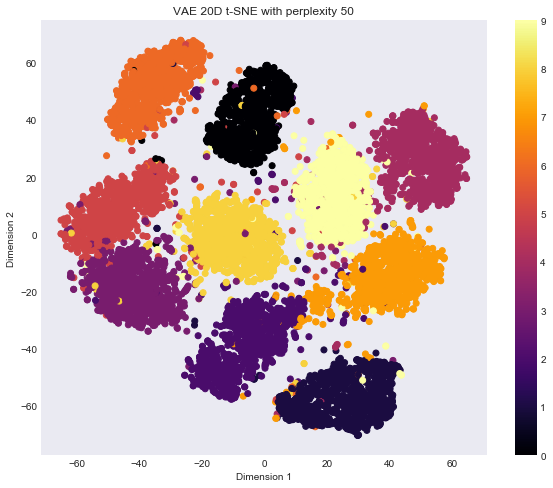

In [16]:
plt.figure(figsize=(10,8))
plt.title("VAE 20D t-SNE with perplexity 50")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.scatter(z_means_proj2[:, 0], z_means_proj2[:, 1], c = all_labels, cmap='inferno')
plt.colorbar()
plt.show()

## Representation of points in latent space - PCA

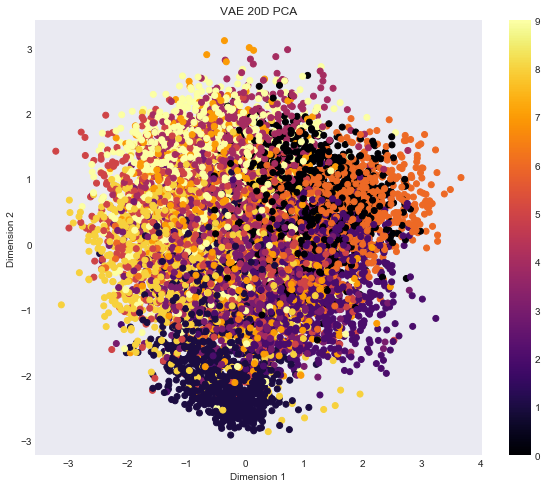

In [17]:
pca = PCA(n_components=2)
z_means_pca =  pca.fit_transform(z_means)
plt.figure(figsize=(10,8))
plt.title("VAE 20D PCA")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.scatter(z_means_pca[:, 0], z_means_pca[:, 1], c=all_labels, cmap='inferno')
plt.colorbar()
plt.show()

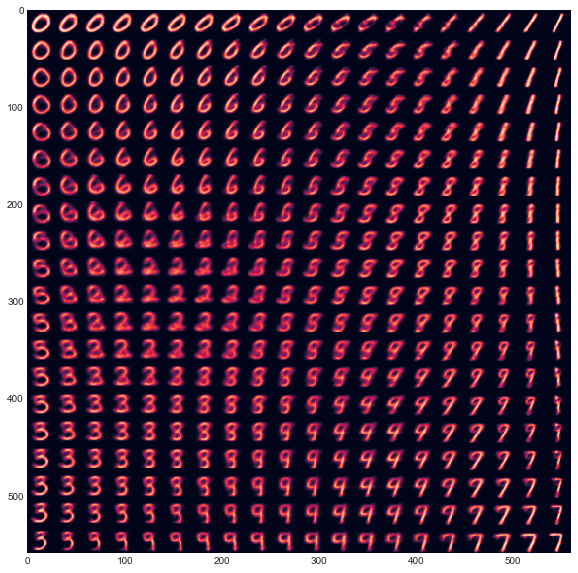

In [17]:
# Visualize digits generated from latent space grid
def visualize_decoder(model,num=20,range_type='g'):
    image_grid = np.zeros([num*28,num*28])

    if range_type == 'l': # linear range
        # corresponds to output range of visualize_encoding()
        range_space = np.linspace(-4,4,num)
    elif range_type == 'g': # gaussian range
        range_space = norm.ppf(np.linspace(0.01,0.99,num))
    else:
        range_space = range_type

    for i, x in enumerate(range_space):
        for j, y in enumerate(reversed(range_space)):
            z = Variable(torch.FloatTensor([[x,y]]))
            image = model.decoder(z)
            image = image.data.numpy()
            image_grid[(j*28):((j+1)*28),(i*28):((i+1)*28)] = image

    plt.figure(figsize=(10, 10))
    plt.imshow(image_grid)
    plt.show()

visualize_decoder(model2)


In [19]:
print(all_labels)

[ 0.  2.  0. ...,  8.  1.  4.]


In [ ]:
#z_means_proj = TSNE(n_components=2).fit_transform(z_means)
#plt.scatter(z_means_proj[:, 0], z_means_proj[:, 1], c=all_labels)

Text(0.5,1,'Perplexity 100')

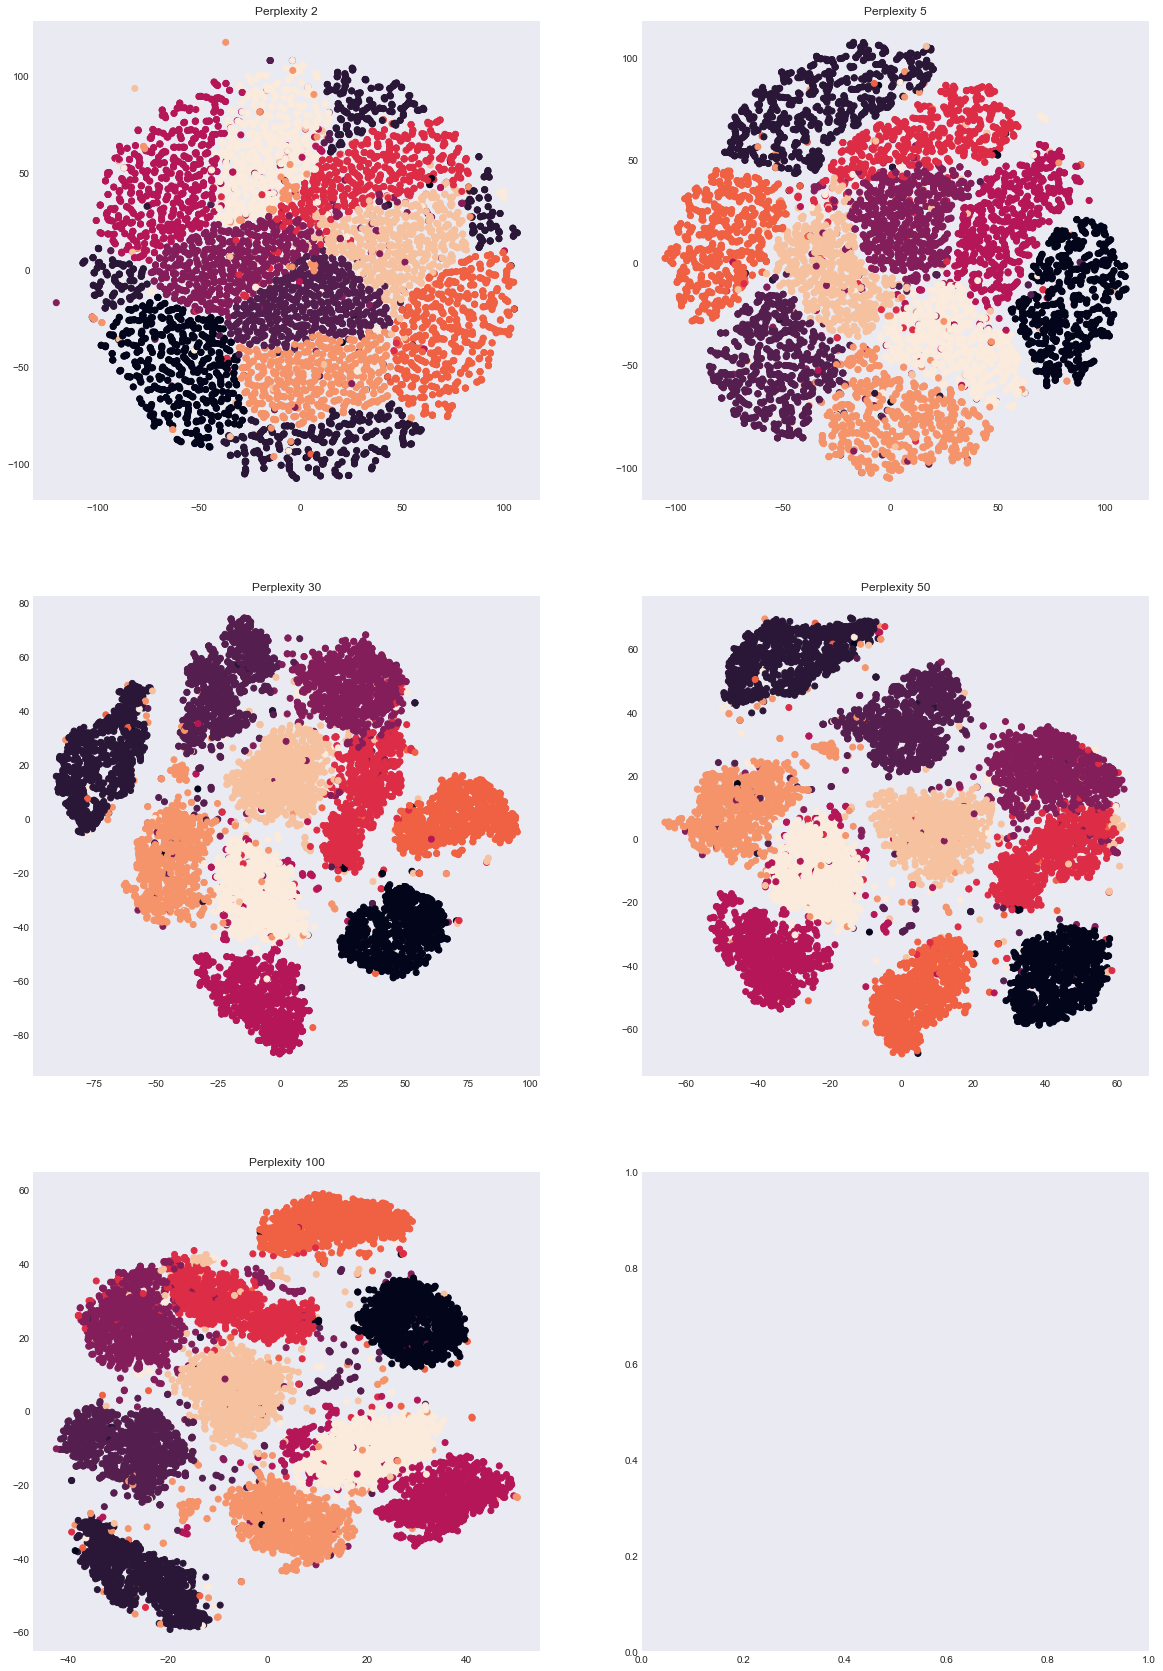

In [20]:
f, axarr = plt.subplots(3, 2, figsize=(20,30))

z_means_proj = TSNE(n_components=2, perplexity=2).fit_transform(z_means)
axarr[0, 0].scatter(z_means_proj[:, 0], z_means_proj[:, 1], c=all_labels)
axarr[0, 0].set_title('Perplexity 2')

z_means_proj = TSNE(n_components=2, perplexity=5).fit_transform(z_means)
axarr[0, 1].scatter(z_means_proj[:, 0], z_means_proj[:, 1], c=all_labels)
axarr[0, 1].set_title('Perplexity 5')

z_means_proj = TSNE(n_components=2, perplexity=30).fit_transform(z_means)
axarr[1, 0].scatter(z_means_proj[:, 0], z_means_proj[:, 1], c=all_labels)
axarr[1, 0].set_title('Perplexity 30')

z_means_proj = TSNE(n_components=2, perplexity=50).fit_transform(z_means)
axarr[1, 1].scatter(z_means_proj[:, 0], z_means_proj[:, 1], c=all_labels)
axarr[1, 1].set_title('Perplexity 50')

z_means_proj = TSNE(n_components=2, perplexity=100).fit_transform(z_means)
axarr[2, 0].scatter(z_means_proj[:, 0], z_means_proj[:, 1], c=all_labels)
axarr[2, 0].set_title('Perplexity 100')

In [18]:
import umap

In [19]:
%%time
embedding = umap.UMAP(n_neighbors=10,
                      min_dist=0.001,
                      metric='correlation').fit_transform(z_means)

Wall time: 21.3 s


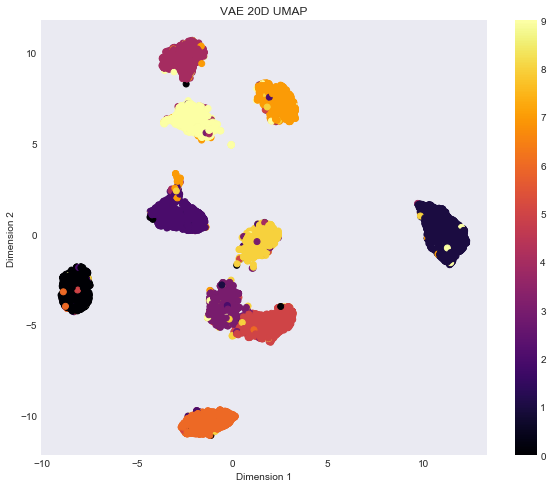

In [20]:
plt.figure(figsize=(10,8))
plt.title("VAE 20D UMAP")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.scatter(embedding[:, 0], embedding[:, 1], c=all_labels, cmap='inferno')
plt.colorbar()
plt.show()